# Inflation Forecasting Using Time Series Analysis

## Import Libraries, Packages, and Data

In [628]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install plotly
!pip install statsmodels
!pip install sklearn
!pip install seaborn
!pip install fredapi

  Using cached fredapi-0.5.0-py3-none-any.whl (11 kB)


In [1006]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot") 
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [1007]:
from fredapi import Fred

fred_api_key = "f8f17d6a6cd348400a30a77bbcc4c14a"
fred = Fred(api_key = fred_api_key)

In [1008]:
df_unrate = fred.get_series_latest_release("UNRATE").to_frame()
df_unrate.reset_index(inplace = True)
df_unrate.rename(columns = {"index":"Date", 0:"Unemployment"}, inplace = True)

df_psr = fred.get_series_latest_release("PSAVERT").to_frame()
df_psr.reset_index(inplace = True)
df_psr.rename(columns = {"index":"Date", 0:"PSR"}, inplace = True)

df_m2 = fred.get_series_latest_release("M2SL").to_frame()
df_m2.reset_index(inplace = True)
df_m2.rename(columns = {"index":"Date", 0:"M2"}, inplace = True)

df_dispinc = fred.get_series_latest_release("DSPIC96").to_frame()
df_dispinc.reset_index(inplace = True)
df_dispinc.rename(columns = {"index":"Date", 0:"DispInc"}, inplace = True)

df_pce = fred.get_series_latest_release("PCE").to_frame()
df_pce.reset_index(inplace = True)
df_pce.rename(columns = {"index":"Date", 0:"PCE"}, inplace = True)

df_ex = fred.get_series_latest_release("RBUSBIS").to_frame()
df_ex.reset_index(inplace = True)
df_ex.rename(columns = {"index":"Date", 0:"ExRate"}, inplace = True)

df_t10y = fred.get_series_latest_release("DGS10").to_frame()
df_t10y.reset_index(inplace = True)
df_t10y.rename(columns = {"index":"Date", 0:"T10Y"}, inplace = True)

df_ffr = fred.get_series_latest_release("FEDFUNDS").to_frame()
df_ffr.reset_index(inplace = True)
df_ffr.rename(columns = {"index":"Date", 0:"FFR"}, inplace = True)

df_construc = fred.get_series_latest_release("TTLCONS").to_frame()
df_construc.reset_index(inplace = True)
df_construc.rename(columns = {"index":"Date", 0:"Construction"}, inplace = True)

df_ind = fred.get_series_latest_release("INDPRO").to_frame()
df_ind.reset_index(inplace = True)
df_ind.rename(columns = {"index":"Date", 0:"IndPro"}, inplace = True)

df_ccpi = fred.get_series_latest_release("CPILFESL").to_frame()
df_ccpi.reset_index(inplace = True)
df_ccpi.rename(columns = {"index":"Date", 0:"CCPI"}, inplace = True)

In [1009]:
max(df_unrate["Date"].min(), df_psr["Date"].min(), df_m2["Date"].min(), df_dispinc["Date"].min(), df_pce["Date"].min(), 
    df_ex["Date"].min(), df_t10y["Date"].min(), df_ffr["Date"].min(), df_construc["Date"].min(), df_ind["Date"].min(), 
    df_ccpi["Date"].min())

Timestamp('1994-01-01 00:00:00')

In [1010]:
df = pd.DataFrame(columns = ["Date"])
df["Date"] = pd.date_range("1994-01-01", datetime.now(), freq = "D")

In [1011]:
df = pd.merge(df, df_unrate, on = "Date", how = "left")
df = pd.merge(df, df_psr, on = "Date", how = "left")
df = pd.merge(df, df_m2, on = "Date", how = "left")
df = pd.merge(df, df_dispinc, on = "Date", how = "left")
df = pd.merge(df, df_pce, on = "Date", how = "left")
df = pd.merge(df, df_ex, on = "Date", how = "left")
df = pd.merge(df, df_t10y, on = "Date", how = "left")
df = pd.merge(df, df_ffr, on = "Date", how = "left")
df = pd.merge(df, df_construc, on = "Date", how = "left")
df = pd.merge(df, df_ind, on = "Date", how = "left")
df = pd.merge(df, df_ccpi, on = "Date", how = "left")

In [1012]:
df.head()

,Date,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI
0,1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,105.2,NaN,3.05,513314.0,66.9164,154.5
1,1994-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994-01-03,NaN,NaN,NaN,NaN,NaN,NaN,5.92,NaN,NaN,NaN,NaN
3,1994-01-04,NaN,NaN,NaN,NaN,NaN,NaN,5.88,NaN,NaN,NaN,NaN
4,1994-01-05,NaN,NaN,NaN,NaN,NaN,NaN,5.90,NaN,NaN,NaN,NaN


#### About this Dataset:

* Unemployment = unemployment rate
* PSR = personal savings rate
* M2 = money supply 
* DispInc = real disposable personal income
* PCE = personal consumption expenditures
* ExRate = real broad effective exchange rate
* T10Y = market yield on US 10Y constant maturity treasury securities
* FFR = federal funds effective rate
* Construction = total construction spending
* IndPro = industrial production index
* CCPI = core CPI

## Data Wrangling 

#### Null Values

In [1013]:
df["Year"] = df["Date"].dt.year
df["Quarter"] = df["Date"].dt.quarter
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day

In [1014]:
df.head()

,Date,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day
0,1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,105.2,NaN,3.05,513314.0,66.9164,154.5,1994,1,1,1
1,1994-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994,1,1,2
2,1994-01-03,NaN,NaN,NaN,NaN,NaN,NaN,5.92,NaN,NaN,NaN,NaN,1994,1,1,3
3,1994-01-04,NaN,NaN,NaN,NaN,NaN,NaN,5.88,NaN,NaN,NaN,NaN,1994,1,1,4
4,1994-01-05,NaN,NaN,NaN,NaN,NaN,NaN,5.90,NaN,NaN,NaN,NaN,1994,1,1,5


In [1015]:
df_copy = df.copy()
df_copy.fillna(method = "bfill", inplace = True)

In [1016]:
df_copy.head()

,Date,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day
0,1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,105.20,5.92,3.05,513314.0,66.9164,154.5,1994,1,1,1
1,1994-01-02,6.6,6.5,3475.7,7377.2,4632.6,104.66,5.92,3.25,513196.0,66.9642,154.8,1994,1,1,2
2,1994-01-03,6.6,6.5,3475.7,7377.2,4632.6,104.66,5.92,3.25,513196.0,66.9642,154.8,1994,1,1,3
3,1994-01-04,6.6,6.5,3475.7,7377.2,4632.6,104.66,5.88,3.25,513196.0,66.9642,154.8,1994,1,1,4
4,1994-01-05,6.6,6.5,3475.7,7377.2,4632.6,104.66,5.90,3.25,513196.0,66.9642,154.8,1994,1,1,5


In [1017]:
df["T10Y"] = df_copy["T10Y"].values

In [1018]:
df.head()

,Date,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day
0,1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,105.2,5.92,3.05,513314.0,66.9164,154.5,1994,1,1,1
1,1994-01-02,NaN,NaN,NaN,NaN,NaN,NaN,5.92,NaN,NaN,NaN,NaN,1994,1,1,2
2,1994-01-03,NaN,NaN,NaN,NaN,NaN,NaN,5.92,NaN,NaN,NaN,NaN,1994,1,1,3
3,1994-01-04,NaN,NaN,NaN,NaN,NaN,NaN,5.88,NaN,NaN,NaN,NaN,1994,1,1,4
4,1994-01-05,NaN,NaN,NaN,NaN,NaN,NaN,5.90,NaN,NaN,NaN,NaN,1994,1,1,5


In [1019]:
df = df[df["Day"] == 1]

In [1020]:
df.head()

,Date,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day
0,1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,105.20,5.92,3.05,513314.0,66.9164,154.5,1994,1,1,1
31,1994-02-01,6.6,6.5,3475.7,7377.2,4632.6,104.66,5.77,3.25,513196.0,66.9642,154.8,1994,1,2,1
59,1994-03-01,6.5,6.8,3480.1,7401.7,4646.0,104.78,6.28,3.34,521040.0,67.6335,155.3,1994,1,3,1
90,1994-04-01,6.4,6.4,3481.3,7402.0,4671.1,104.68,7.16,3.56,528063.0,68.0334,155.5,1994,2,4,1
120,1994-05-01,6.1,7.6,3490.8,7487.4,4669.5,103.78,7.09,4.01,532328.0,68.3531,155.9,1994,2,5,1


In [1021]:
df.isnull().sum()

Date            0
Unemployment    1
PSR             2
M2              2
DispInc         2
PCE             2
ExRate          2
T10Y            0
FFR             1
Construction    2
IndPro          2
CCPI            2
Year            0
Quarter         0
Month           0
Day             0
dtype: int64

In [1022]:
df[df["PSR"].isna()]

,Date,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day
10470,2022-09-01,3.5,NaN,NaN,NaN,NaN,NaN,3.26,2.56,NaN,NaN,NaN,2022,3,9,1
10500,2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,3.67,NaN,NaN,NaN,NaN,2022,4,10,1


In [1023]:
df.tail()

,Date,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day
10378,2022-06-01,3.6,3.0,21667.3,15013.1,17437.4,127.55,2.94,1.21,1803791.0,104.1778,294.354,2022,2,6,1
10408,2022-07-01,3.5,3.5,21709.6,15081.4,17402.6,129.64,2.88,1.68,1793514.0,104.7189,295.275,2022,3,7,1
10439,2022-08-01,3.7,3.5,21711.4,15093.2,17470.1,128.97,2.60,2.33,1781278.0,104.5464,296.950,2022,3,8,1
10470,2022-09-01,3.5,NaN,NaN,NaN,NaN,NaN,3.26,2.56,NaN,NaN,NaN,2022,3,9,1
10500,2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,3.67,NaN,NaN,NaN,NaN,2022,4,10,1


In [1024]:
df.dropna(inplace = True)

In [1025]:
df.isnull().sum()

Date            0
Unemployment    0
PSR             0
M2              0
DispInc         0
PCE             0
ExRate          0
T10Y            0
FFR             0
Construction    0
IndPro          0
CCPI            0
Year            0
Quarter         0
Month           0
Day             0
dtype: int64

#### Data Types and Aggregates

In [1026]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 0 to 10439
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          344 non-null    datetime64[ns]
 1   Unemployment  344 non-null    float64       
 2   PSR           344 non-null    float64       
 3   M2            344 non-null    float64       
 4   DispInc       344 non-null    float64       
 5   PCE           344 non-null    float64       
 6   ExRate        344 non-null    float64       
 7   T10Y          344 non-null    float64       
 8   FFR           344 non-null    float64       
 9   Construction  344 non-null    float64       
 10  IndPro        344 non-null    float64       
 11  CCPI          344 non-null    float64       
 12  Year          344 non-null    int64         
 13  Quarter       344 non-null    int64         
 14  Month         344 non-null    int64         
 15  Day           344 non-null    int64   

In [1027]:
df.describe()

,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,3.440000e+02,344.000000,344.000000,344.000000,344.000000,344.000000,344.0
mean,5.730814,6.575291,9009.504070,11517.469186,9791.422674,110.301337,3.832064,2.365669,9.971754e+05,93.002424,214.643049,2007.837209,2.485465,6.453488,1.0
std,1.791715,3.153359,4824.146957,2414.955529,3310.927753,9.153691,1.761563,2.224943,3.040856e+05,9.250571,35.928902,8.289036,1.116961,3.447759,0.0
min,3.500000,2.100000,3474.900000,7363.100000,4585.100000,93.060000,0.560000,0.050000,5.131960e+05,66.916400,154.500000,1994.000000,1.000000,1.000000,1.0
25%,4.500000,5.000000,5057.525000,9693.275000,7000.525000,102.270000,2.357500,0.160000,8.018655e+05,89.107375,184.625000,2001.000000,1.000000,3.000000,1.0
50%,5.350000,6.500000,7705.200000,11541.950000,9867.550000,111.325000,3.775000,1.715000,9.351475e+05,95.295100,214.748000,2008.000000,2.000000,6.000000,1.0
75%,6.125000,7.300000,12018.950000,13300.550000,12242.775000,116.822500,5.110000,4.857500,1.172620e+06,100.068800,242.189250,2015.000000,3.000000,9.000000,1.0
max,14.700000,33.800000,21739.800000,19213.900000,17470.100000,129.640000,7.920000,6.540000,1.803791e+06,104.718900,296.950000,2022.000000,4.000000,12.000000,1.0


## Feature Engineering

In [1028]:
df.head()

,Date,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day
0,1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,105.20,5.92,3.05,513314.0,66.9164,154.5,1994,1,1,1
31,1994-02-01,6.6,6.5,3475.7,7377.2,4632.6,104.66,5.77,3.25,513196.0,66.9642,154.8,1994,1,2,1
59,1994-03-01,6.5,6.8,3480.1,7401.7,4646.0,104.78,6.28,3.34,521040.0,67.6335,155.3,1994,1,3,1
90,1994-04-01,6.4,6.4,3481.3,7402.0,4671.1,104.68,7.16,3.56,528063.0,68.0334,155.5,1994,2,4,1
120,1994-05-01,6.1,7.6,3490.8,7487.4,4669.5,103.78,7.09,4.01,532328.0,68.3531,155.9,1994,2,5,1


In [1029]:
df["Unemployment MoM Change"] = round(df["Unemployment"].pct_change().fillna(0) * 100, 2)
df["Unemployment YoY Change"] = round(df["Unemployment"].pct_change(12).fillna(0) * 100, 2)

df["PSR MoM Change"] = round(df["PSR"].pct_change().fillna(0) * 100, 2)
df["PSR YoY Change"] = round(df["PSR"].pct_change(12).fillna(0) * 100, 2)

df["M2 MoM Change"] = round(df["M2"].pct_change().fillna(0) * 100, 2)
df["M2 YoY Change"] = round(df["M2"].pct_change(12).fillna(0) * 100, 2)

df["DispInc MoM Change"] = round(df["DispInc"].pct_change().fillna(0) * 100, 2)
df["DispInc YoY Change"] = round(df["DispInc"].pct_change(12).fillna(0) * 100, 2)

df["PCE MoM Change"] = round(df["PCE"].pct_change().fillna(0) * 100, 2)
df["PCE YoY Change"] = round(df["PCE"].pct_change(12).fillna(0) * 100, 2)

df["ExRate MoM Change"] = round(df["ExRate"].pct_change().fillna(0) * 100, 2)
df["ExRate YoY Change"] = round(df["ExRate"].pct_change(12).fillna(0) * 100, 2)

df["T10Y MoM Change"] = round(df["T10Y"].pct_change().fillna(0) * 100, 2)
df["T10Y YoY Change"] = round(df["T10Y"].pct_change(12).fillna(0) * 100, 2)

df["FFR MoM Change"] = round(df["FFR"].pct_change().fillna(0) * 100, 2)
df["FFR YoY Change"] = round(df["FFR"].pct_change(12).fillna(0) * 100, 2)

df["Construction MoM Change"] = round(df["Construction"].pct_change().fillna(0) * 100, 2)
df["Construction YoY Change"] = round(df["Construction"].pct_change(12).fillna(0) * 100, 2)

df["IndProd MoM Change"] = round(df["IndPro"].pct_change().fillna(0) * 100, 2)
df["IndProd YoY Change"] = round(df["IndPro"].pct_change(12).fillna(0) * 100, 2)

df["CCPI MoM Change"] = round(df["CCPI"].pct_change().fillna(0) * 100, 2)
df["CCPI YoY Change"] = round(df["CCPI"].pct_change(12).fillna(0) * 100, 2)

In [1030]:
df.head()

,Date,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day,Unemployment MoM Change,Unemployment YoY Change,PSR MoM Change,PSR YoY Change,M2 MoM Change,M2 YoY Change,DispInc MoM Change,DispInc YoY Change,PCE MoM Change,PCE YoY Change,ExRate MoM Change,ExRate YoY Change,T10Y MoM Change,T10Y YoY Change,FFR MoM Change,FFR YoY Change,Construction MoM Change,Construction YoY Change,IndProd MoM Change,IndProd YoY Change,CCPI MoM Change,CCPI YoY Change
0,1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,105.20,5.92,3.05,513314.0,66.9164,154.5,1994,1,1,1,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
31,1994-02-01,6.6,6.5,3475.7,7377.2,4632.6,104.66,5.77,3.25,513196.0,66.9642,154.8,1994,1,2,1,0.00,0.0,-8.45,0.0,0.02,0.0,0.19,0.0,1.04,0.0,-0.51,0.0,-2.53,0.0,6.56,0.0,-0.02,0.0,0.07,0.0,0.19,0.0
59,1994-03-01,6.5,6.8,3480.1,7401.7,4646.0,104.78,6.28,3.34,521040.0,67.6335,155.3,1994,1,3,1,-1.52,0.0,4.62,0.0,0.13,0.0,0.33,0.0,0.29,0.0,0.11,0.0,8.84,0.0,2.77,0.0,1.53,0.0,1.00,0.0,0.32,0.0
90,1994-04-01,6.4,6.4,3481.3,7402.0,4671.1,104.68,7.16,3.56,528063.0,68.0334,155.5,1994,2,4,1,-1.54,0.0,-5.88,0.0,0.03,0.0,0.00,0.0,0.54,0.0,-0.10,0.0,14.01,0.0,6.59,0.0,1.35,0.0,0.59,0.0,0.13,0.0
120,1994-05-01,6.1,7.6,3490.8,7487.4,4669.5,103.78,7.09,4.01,532328.0,68.3531,155.9,1994,2,5,1,-4.69,0.0,18.75,0.0,0.27,0.0,1.15,0.0,-0.03,0.0,-0.86,0.0,-0.98,0.0,12.64,0.0,0.81,0.0,0.47,0.0,0.26,0.0


## Exploratory Data Analysis

#### Feature Trends

array([[<AxesSubplot: title={'center': 'Date'}>,
        <AxesSubplot: title={'center': 'Unemployment'}>,
        <AxesSubplot: title={'center': 'PSR'}>],
       [<AxesSubplot: title={'center': 'M2'}>,
        <AxesSubplot: title={'center': 'DispInc'}>,
        <AxesSubplot: title={'center': 'PCE'}>],
       [<AxesSubplot: title={'center': 'ExRate'}>,
        <AxesSubplot: title={'center': 'T10Y'}>,
        <AxesSubplot: title={'center': 'FFR'}>],
       [<AxesSubplot: title={'center': 'Construction'}>,
        <AxesSubplot: title={'center': 'IndPro'}>,
        <AxesSubplot: title={'center': 'CCPI'}>]], dtype=object)

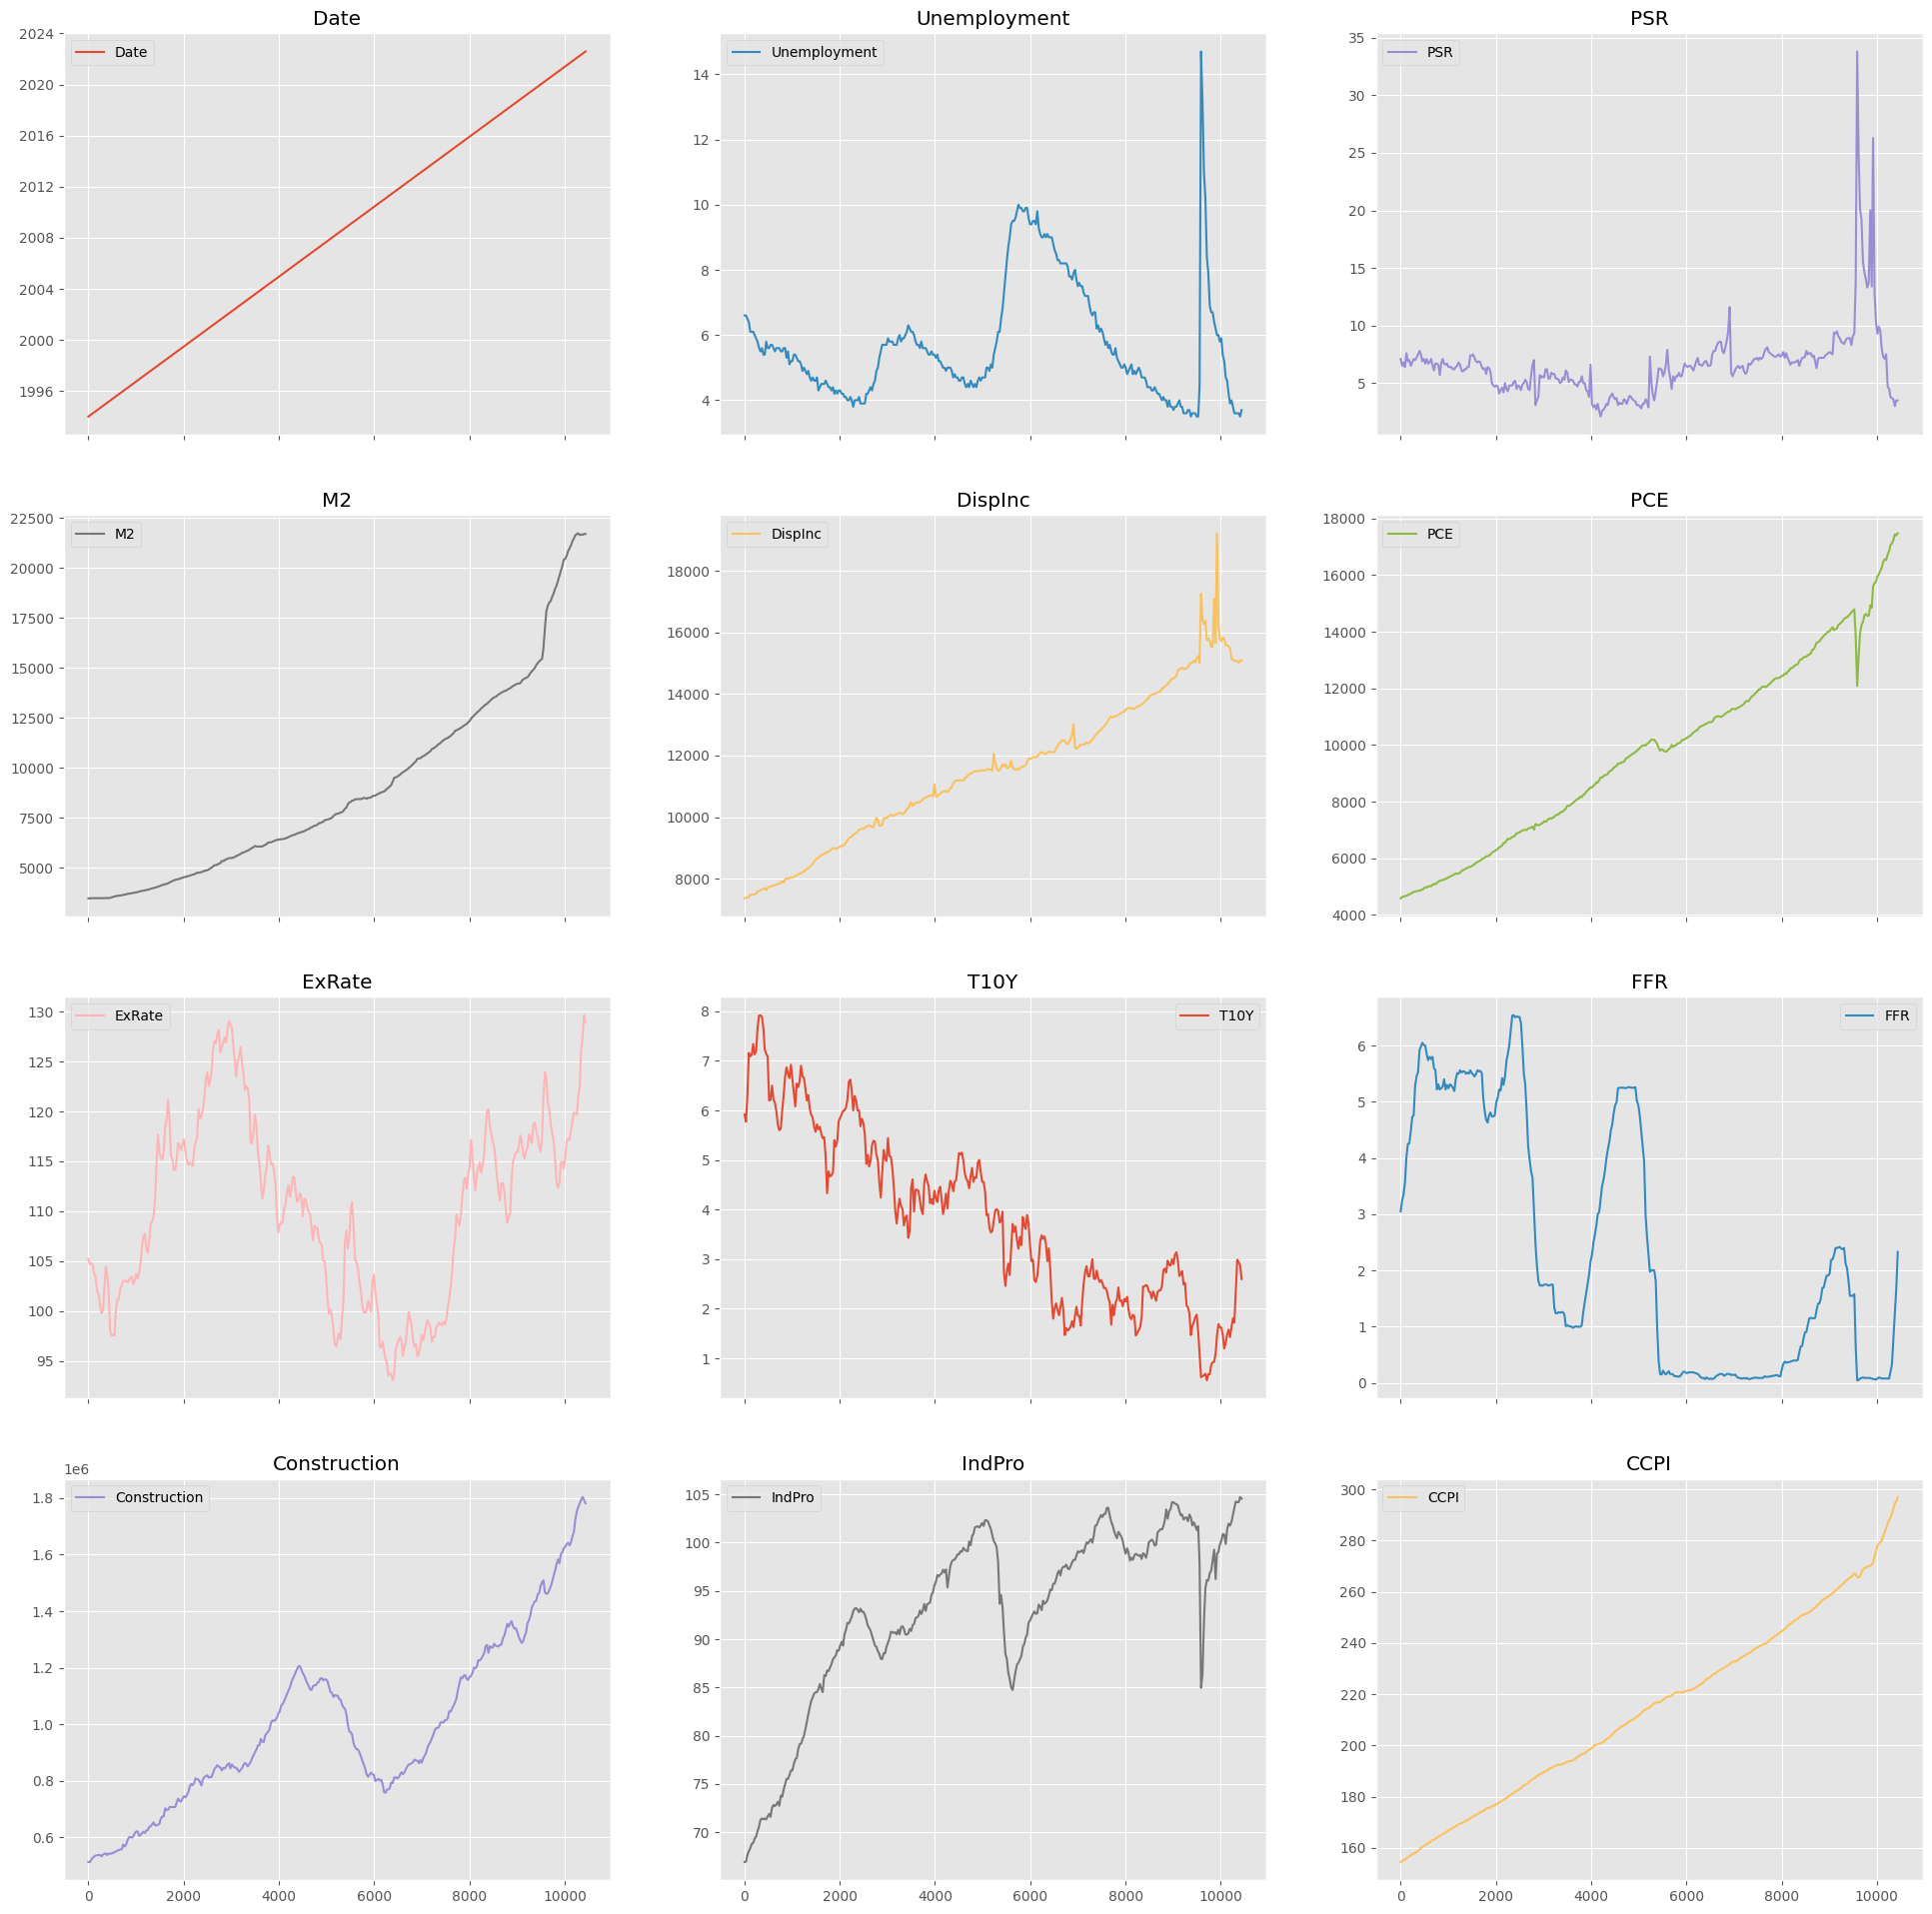

In [1031]:
df.loc[:, "Date":"CCPI"].plot(kind = "line", 
                                      subplots = True, 
                                      layout = (4, 3), 
                                      figsize = (24, 24), 
                                      title = df.loc[:, "Date":"CCPI"].columns.to_list(), 
                                      legend = True, 
                                      sharex = True)

#### CPI Trend by Month and Quarter

In [1032]:
fig1 = px.box(df, x = "Month", y = "CCPI YoY Change", points = "all")
fig2 = px.box(df, x = "Quarter", y = "CCPI YoY Change", points = "all")
fig1.show()
fig2.show()

In [1033]:
fig1 = px.bar(df.groupby(["Month"]).std()[["CCPI YoY Change"]].reset_index(), x = "Month", y = "CCPI YoY Change", 
             text = "CCPI YoY Change").update_traces(texttemplate = "%{text:0.3f}", textposition = "outside").update_xaxes(nticks = 13)

fig2 = px.bar(df.groupby(["Quarter"]).std()[["CCPI YoY Change"]].reset_index(), x = "Quarter", y = "CCPI YoY Change", 
             text = "CCPI YoY Change").update_traces(texttemplate = "%{text:0.3f}", textposition = 'outside').update_xaxes(nticks = 5)

fig1.show()
fig2.show()

* The value of YoY change in core CPI does not show any significant differences between months or quarters.
* There appears to be less deviation in the YoY change in core CPI in the first quarter of the year.

## Forecasting Inflation: ARIMA

In [1034]:
df_model = df.set_index("Date")
df_model.head()

,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day,Unemployment MoM Change,Unemployment YoY Change,PSR MoM Change,PSR YoY Change,M2 MoM Change,M2 YoY Change,DispInc MoM Change,DispInc YoY Change,PCE MoM Change,PCE YoY Change,ExRate MoM Change,ExRate YoY Change,T10Y MoM Change,T10Y YoY Change,FFR MoM Change,FFR YoY Change,Construction MoM Change,Construction YoY Change,IndProd MoM Change,IndProd YoY Change,CCPI MoM Change,CCPI YoY Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,105.20,5.92,3.05,513314.0,66.9164,154.5,1994,1,1,1,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
1994-02-01,6.6,6.5,3475.7,7377.2,4632.6,104.66,5.77,3.25,513196.0,66.9642,154.8,1994,1,2,1,0.00,0.0,-8.45,0.0,0.02,0.0,0.19,0.0,1.04,0.0,-0.51,0.0,-2.53,0.0,6.56,0.0,-0.02,0.0,0.07,0.0,0.19,0.0
1994-03-01,6.5,6.8,3480.1,7401.7,4646.0,104.78,6.28,3.34,521040.0,67.6335,155.3,1994,1,3,1,-1.52,0.0,4.62,0.0,0.13,0.0,0.33,0.0,0.29,0.0,0.11,0.0,8.84,0.0,2.77,0.0,1.53,0.0,1.00,0.0,0.32,0.0
1994-04-01,6.4,6.4,3481.3,7402.0,4671.1,104.68,7.16,3.56,528063.0,68.0334,155.5,1994,2,4,1,-1.54,0.0,-5.88,0.0,0.03,0.0,0.00,0.0,0.54,0.0,-0.10,0.0,14.01,0.0,6.59,0.0,1.35,0.0,0.59,0.0,0.13,0.0
1994-05-01,6.1,7.6,3490.8,7487.4,4669.5,103.78,7.09,4.01,532328.0,68.3531,155.9,1994,2,5,1,-4.69,0.0,18.75,0.0,0.27,0.0,1.15,0.0,-0.03,0.0,-0.86,0.0,-0.98,0.0,12.64,0.0,0.81,0.0,0.47,0.0,0.26,0.0


#### Time Series Decomposition

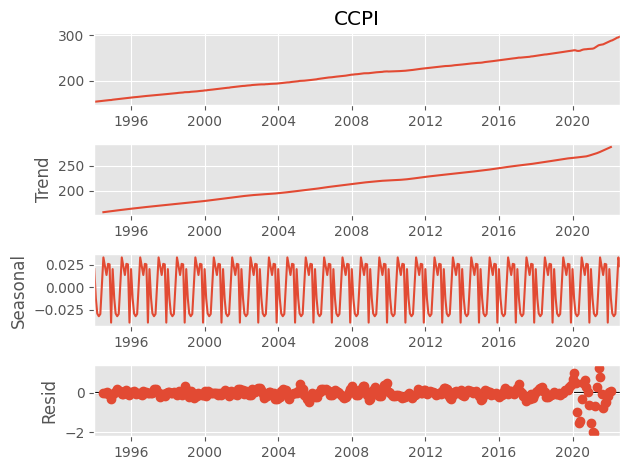

In [1035]:
fig = seasonal_decompose(df_model["CCPI"], model = "additive").plot()

*Core CPI show non-stationarity*
* Trend: increasing over time
* Seasonal: there are repeating seasonal trends
* Residuals: the variability that cannot be explained by trend and seasonality grew significantly beginning in 2020

#### Split into Training and Testing Sets
Since the entire data set is 27 years (1994 to 2021), the test data will be the most recent 5 years / 60 months (~20% of the total data)

In [1036]:
train_data = df_model[0 : len(df_model) - 60]
test_data = df_model.iloc[len(df_model) - 60 :]

In [1037]:
train_data.tail(1)

,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day,Unemployment MoM Change,Unemployment YoY Change,PSR MoM Change,PSR YoY Change,M2 MoM Change,M2 YoY Change,DispInc MoM Change,DispInc YoY Change,PCE MoM Change,PCE YoY Change,ExRate MoM Change,ExRate YoY Change,T10Y MoM Change,T10Y YoY Change,FFR MoM Change,FFR YoY Change,Construction MoM Change,Construction YoY Change,IndProd MoM Change,IndProd YoY Change,CCPI MoM Change,CCPI YoY Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-01,4.4,7.6,13679.6,14003.4,13234.1,111.94,2.26,1.16,1274859.0,99.6878,252.535,2017,3,8,1,2.33,-10.2,0.0,11.76,0.43,5.4,0.05,3.13,0.31,3.8,-1.24,-1.69,-3.83,49.67,0.87,190.0,-0.17,3.51,-0.45,0.97,0.22,1.66


In [1038]:
test_data.head(1)

,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day,Unemployment MoM Change,Unemployment YoY Change,PSR MoM Change,PSR YoY Change,M2 MoM Change,M2 YoY Change,DispInc MoM Change,DispInc YoY Change,PCE MoM Change,PCE YoY Change,ExRate MoM Change,ExRate YoY Change,T10Y MoM Change,T10Y YoY Change,FFR MoM Change,FFR YoY Change,Construction MoM Change,Construction YoY Change,IndProd MoM Change,IndProd YoY Change,CCPI MoM Change,CCPI YoY Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-01,4.3,7.3,13722.1,14021.4,13353.4,111.09,2.16,1.15,1281382.0,99.7829,252.812,2017,3,9,1,-2.27,-14.0,-3.95,7.35,0.31,5.25,0.13,3.04,0.9,4.27,-0.76,-3.06,-4.42,37.58,-0.86,187.5,0.51,3.26,0.1,1.17,0.11,1.6


<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

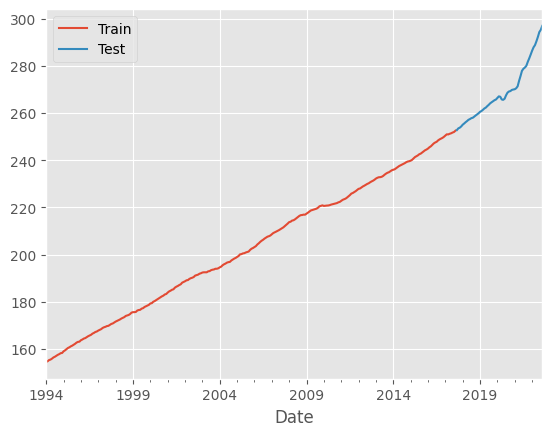

In [1039]:
train_data["CCPI"].plot()
test_data["CCPI"].plot()
plt.legend(labels = ["Train", "Test"])

#### Determmine <code>d</code>
d = minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

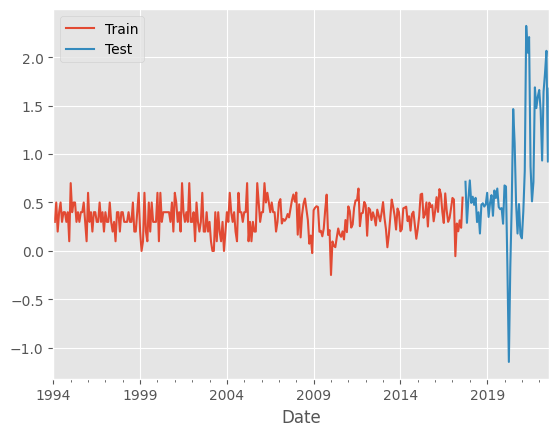

In [1040]:
train_data["CCPI"].diff().plot()
test_data["CCPI"].diff().plot()
plt.legend(labels = ["Train", "Test"])

In [1041]:
diff = train_data["CCPI"].diff().dropna()
p = adfuller(diff.values)[1]
print("p-value =", p)

p-value = 0.00599809802309418


Since the p-value of the Augmented Dickey-Fuller test on the training data with difference of 1 is less than 0.05, <code>d = 1<code\>

#### Determine <code>p</code>
p = number of AR terms (number of lags of Y to be used as predictors) is determined by inspecting the PACF plot 

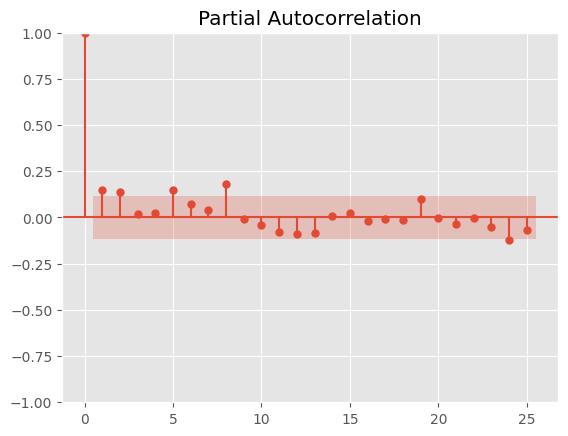

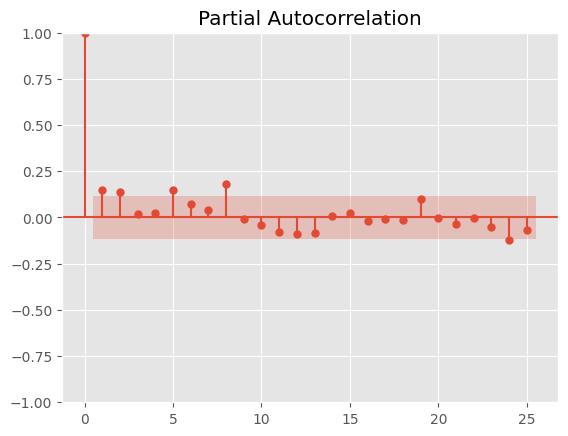

In [1042]:
plot_pacf(diff.values)

Based on the partial autocorrelation charts, <code>p = 1<code\>

#### Determine <code>q</code>
q = number of MA terms (number of lagged forecast errors to use as predictors) is determined by inspecting the ACF plot 

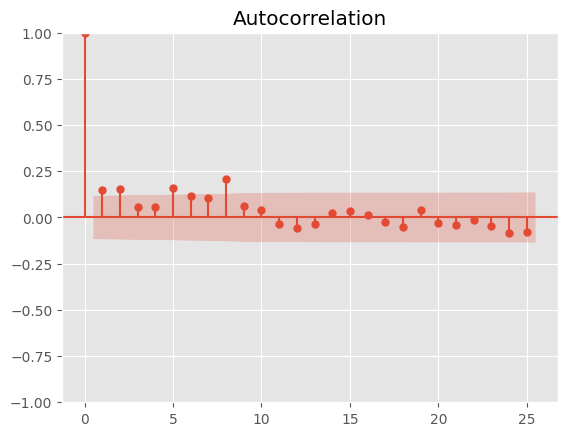

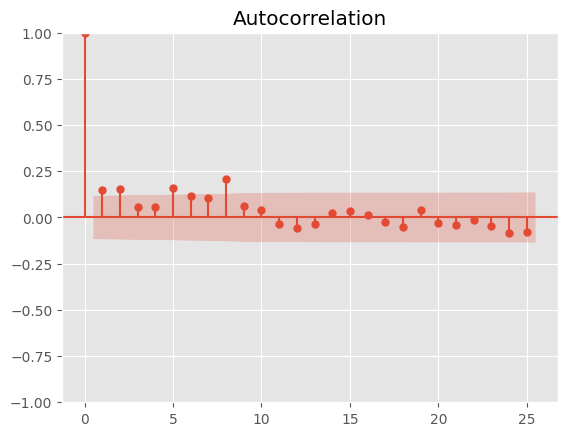

In [1043]:
plot_acf(diff.values)

Based on the autocorrelation charts, <code>q = 1<code\>

#### Building the ARIMA Model

In [1044]:
arima_model = ARIMA(train_data["CCPI"], order = (1, 1, 1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   CCPI   No. Observations:                  284
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 122.851
Date:                Sun, 09 Oct 2022   AIC                           -239.701
Time:                        11:57:41   BIC                           -228.765
Sample:                    01-01-1994   HQIC                          -235.316
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.003    360.123      0.000       0.993       1.004
ma.L1         -0.8703      0.030    -28.800      0.000      -0.929      -0.811
sigma2         0.0243      0.002     12.817      0.000       0.021       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.74   Prob(JB):                         0.42
Heteroskedasticity (H):               1.04   Skew:                            -0.09
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Forecasting with the ARIMA Model

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Forecast vs Actuals')

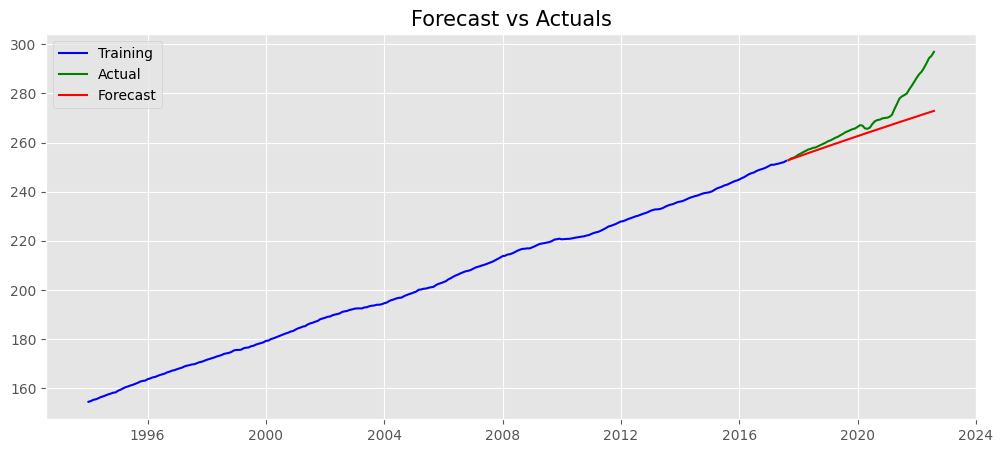

In [1045]:
forecast = arima_model.forecast(steps = 60)

plt.figure(figsize = (12, 5))
plt.plot(train_data["CCPI"], label = "Training", color = "blue")
plt.plot(test_data["CCPI"], label = "Actual", color = "green")
plt.plot(forecast, label = "Forecast", color = "red")

plt.title("Forecast vs Actuals", fontsize = 15)
plt.legend(fontsize = 10)
plt.show()

#### Evaluating ARIMA Model

Total Error

In [1046]:
MSE_arima = mean_squared_error(test_data["CCPI"].values, forecast.values)
print("MSE =", MSE_arima)

MSE = 75.65027748035963


Pre-COVID Error

In [1047]:
pre_covid_test = test_data[test_data.index < pd.Timestamp(2020, 2, 1)]["CCPI"].values
pre_covid_test

array([252.812, 253.526, 253.816, 254.344, 255.072, 255.568, 256.128,
       256.603, 257.151, 257.449, 257.848, 258.028, 258.505, 258.997,
       259.455, 259.934, 260.534, 260.885, 261.382, 261.958, 262.321,
       262.945, 263.491, 264.135, 264.588, 265.019, 265.461, 265.742,
       266.418])

In [1048]:
MSE_pre_covid = mean_squared_error(pre_covid_test, forecast.values[0:len(pre_covid_test)])
print("MSE =", MSE_pre_covid)

MSE = 4.67760744224398


The ARIMA model appears to be a somewhat accurate forecaster of Core CPI values and has significantly less error in the pre-COVID forecast. CPI was affected dramatically by COVID due to supply chain issues, demand shifts, and fiscal stimulus; it was a largely unforecastable event, so it is unsurprising that an ARIMA model would have been able to accurately forecast these changes. 

The model can likely be improved if other features are included in the forecasting using multivariate forecasting.

## Forecasting Inflation: Univariate LSTM

Long Short-Term Memory (LSTM) Recurrent Neural Network will be a useful method for forecasting because the lag effect of features (unemployment, savings rate, money supply...) on inflation is not known exactly.

#### Data Preparation for Univariate LSTM Model

In [1049]:
scaler = MinMaxScaler(feature_range = (0, 1))
UL_data = df_model["CCPI"].values
UL_data = scaler.fit_transform(UL_data.reshape(-1, 1))

In [1050]:
UL_train = UL_data[0 : len(UL_data) - 60]
UL_test = UL_data[len(UL_data) - 60 :]

In [1306]:
UL_train.shape, UL_test.shape

((284, 1), (60, 1))

In [1051]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [1052]:
lookback = 12
UL_xtrain, UL_ytrain = split_sequence(UL_train, lookback)
UL_xtest, UL_ytest = split_sequence(UL_test, lookback)

In [1053]:
UL_xtrain.shape

(272, 12, 1)

#### Build Univariate LSTM Model

In [1054]:
UL_model = Sequential()
UL_model.add(LSTM(64, activation = "relu", input_shape = (UL_xtrain.shape[1], UL_xtrain.shape[2])))
UL_model.add(Dense(1))
UL_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mse")

UL_model.fit(UL_xtrain, UL_ytrain, epochs = 200, verbose = 0)

UL_yhat = UL_model.predict(UL_xtest)

2/2 [==============================] - 0s 10ms/step


In [1055]:
UL_ytest = scaler.inverse_transform(UL_ytest)
UL_yhat = scaler.inverse_transform(UL_yhat)

In [1056]:
MSE_UL = mean_squared_error(UL_ytest, UL_yhat)
print("MSE =", MSE_UL)

MSE = 3.509075542002156


This MSE of the Univariate LSTM model (6.6) performed worse than the MSE for the ARIMA model (4.5).

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Forecast vs Actuals')

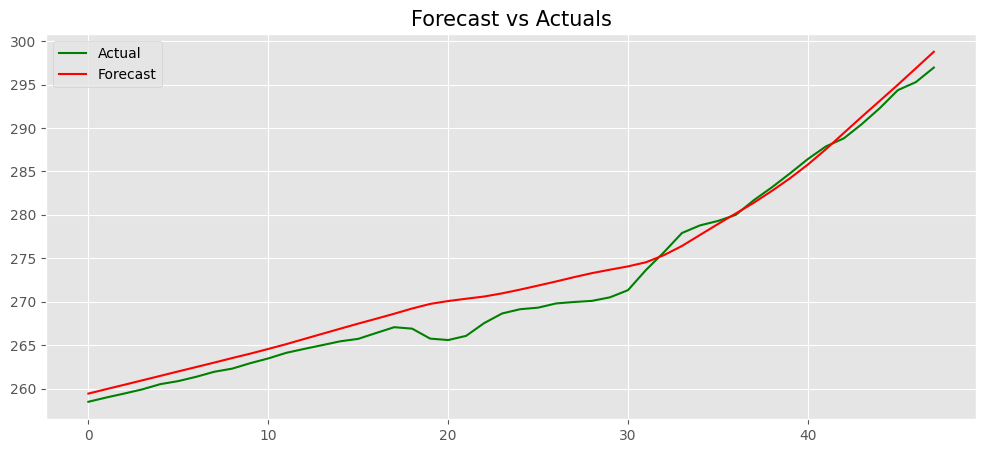

In [1057]:
plt.figure(figsize = (12, 5))
plt.plot(UL_ytest, label = "Actual", color = "green")
plt.plot(UL_yhat, label = "Forecast", color = "red")

plt.title("Forecast vs Actuals", fontsize = 15)
plt.legend(fontsize = 10)
plt.show()

## Forecasting Inflation: Multivariate LSTM

#### Data Preparation for Multivariate LSTM Model

*Feature selection using Granger Causality Test*

In [1531]:
df_model.head()

,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI,Year,Quarter,Month,Day,Unemployment MoM Change,Unemployment YoY Change,PSR MoM Change,PSR YoY Change,M2 MoM Change,M2 YoY Change,DispInc MoM Change,DispInc YoY Change,PCE MoM Change,PCE YoY Change,ExRate MoM Change,ExRate YoY Change,T10Y MoM Change,T10Y YoY Change,FFR MoM Change,FFR YoY Change,Construction MoM Change,Construction YoY Change,IndProd MoM Change,IndProd YoY Change,CCPI MoM Change,CCPI YoY Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,105.20,5.92,3.05,513314.0,66.9164,154.5,1994,1,1,1,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
1994-02-01,6.6,6.5,3475.7,7377.2,4632.6,104.66,5.77,3.25,513196.0,66.9642,154.8,1994,1,2,1,0.00,0.0,-8.45,0.0,0.02,0.0,0.19,0.0,1.04,0.0,-0.51,0.0,-2.53,0.0,6.56,0.0,-0.02,0.0,0.07,0.0,0.19,0.0
1994-03-01,6.5,6.8,3480.1,7401.7,4646.0,104.78,6.28,3.34,521040.0,67.6335,155.3,1994,1,3,1,-1.52,0.0,4.62,0.0,0.13,0.0,0.33,0.0,0.29,0.0,0.11,0.0,8.84,0.0,2.77,0.0,1.53,0.0,1.00,0.0,0.32,0.0
1994-04-01,6.4,6.4,3481.3,7402.0,4671.1,104.68,7.16,3.56,528063.0,68.0334,155.5,1994,2,4,1,-1.54,0.0,-5.88,0.0,0.03,0.0,0.00,0.0,0.54,0.0,-0.10,0.0,14.01,0.0,6.59,0.0,1.35,0.0,0.59,0.0,0.13,0.0
1994-05-01,6.1,7.6,3490.8,7487.4,4669.5,103.78,7.09,4.01,532328.0,68.3531,155.9,1994,2,5,1,-4.69,0.0,18.75,0.0,0.27,0.0,1.15,0.0,-0.03,0.0,-0.86,0.0,-0.98,0.0,12.64,0.0,0.81,0.0,0.47,0.0,0.26,0.0


In [1532]:
# See if 1 differencing makes the features stationary
ML_diff = df_model.loc[:,"Unemployment":"CCPI"].diff().dropna().rename_axis("Indicator", axis = 1)

for col in ML_diff:
    p = adfuller(ML_diff[col])[1]
    if p < 0.05:
        print(col, ": Stationary")
    else:
        print(col, ": NOT Stationary")

Unemployment : Stationary
PSR : Stationary
M2 : NOT Stationary
DispInc : Stationary
PCE : Stationary
ExRate : Stationary
T10Y : Stationary
FFR : Stationary
Construction : NOT Stationary
IndPro : Stationary
CCPI : NOT Stationary


In [1533]:
# M2, Contruction, and CCPI are not stationary after 1 differencing; see if 2 differencings makes them stationary
ML_diff[["M2"]] = ML_diff[["M2"]].diff().dropna()
ML_diff[["Construction"]] = ML_diff[["M2"]].diff().dropna()
ML_diff[["CCPI"]] = ML_diff[["M2"]].diff().dropna()

ML_diff = ML_diff.dropna()
for col in ML_diff:
    p = adfuller(ML_diff[col])[1]
    if p < 0.05:
        print(col, ": Stationary")
    else:
        print(col, ": NOT Stationary")

Unemployment : Stationary
PSR : Stationary
M2 : Stationary
DispInc : Stationary
PCE : Stationary
ExRate : Stationary
T10Y : Stationary
FFR : Stationary
Construction : Stationary
IndPro : Stationary
CCPI : Stationary


In [1534]:
granger_df = pd.DataFrame(np.zeros((len(ML_diff.columns), len(ML_diff.columns))), columns = ML_diff.columns, 
                          index = ML_diff.columns)

max_lag = 24
for col in granger_df.columns:
    for row in granger_df.columns:
        result = grangercausalitytests(ML_diff[[row, col]], maxlag = max_lag, verbose = False)
        p_values = [round(result[i+1][0]["ssr_chi2test"][1], 4) for i in range(max_lag)]
        min_p = np.min(p_values)
        granger_df.loc[row, col] = min_p

In [1535]:
granger_df

Indicator,Unemployment,PSR,M2,DispInc,PCE,ExRate,T10Y,FFR,Construction,IndPro,CCPI
Indicator,,,,,,,,,,,
Unemployment,1.0000,0.0040,0.0000,0.2358,0.0000,0.0016,0.0296,0.0000,0.0000,0.0000,0.0000
PSR,0.0000,1.0000,0.0000,0.0000,0.0000,0.0324,0.1403,0.0000,0.0000,0.0000,0.0000
M2,0.0000,0.0000,1.0000,0.0011,0.0000,0.0051,0.2330,0.0000,0.0000,0.0000,0.0000
DispInc,0.0000,0.0000,0.0000,1.0000,0.0000,0.2445,0.2299,0.0000,0.0000,0.0000,0.0000
PCE,0.0000,0.0001,0.0000,0.0000,1.0000,0.0109,0.2633,0.0000,0.0000,0.0000,0.0000
ExRate,0.1480,0.0561,0.4481,0.0761,0.1350,1.0000,0.0125,0.2678,0.6742,0.1355,0.6742
T10Y,0.5923,0.2949,0.0615,0.2286,0.0994,0.1272,1.0000,0.1283,0.2438,0.2024,0.2438
FFR,0.0216,0.0906,0.2239,0.1704,0.1324,0.3192,0.0002,1.0000,0.4389,0.6062,0.4389
Construction,0.0000,0.0000,0.0000,0.0000,0.0000,0.0028,0.0698,0.0000,1.0000,0.0000,1.0000


Using a p-value threshold of 0.05, the insignificant features are ExRate, T10Y, FFR, and Construction

In [1536]:
ML_data = df_model.loc[:,"Unemployment":"CCPI"].drop(["ExRate", "T10Y", "FFR", "Construction"], axis = 1)
ML_data.head()

,Unemployment,PSR,M2,DispInc,PCE,IndPro,CCPI
Date,,,,,,,
1994-01-01,6.6,7.1,3474.9,7363.1,4585.1,66.9164,154.5
1994-02-01,6.6,6.5,3475.7,7377.2,4632.6,66.9642,154.8
1994-03-01,6.5,6.8,3480.1,7401.7,4646.0,67.6335,155.3
1994-04-01,6.4,6.4,3481.3,7402.0,4671.1,68.0334,155.5
1994-05-01,6.1,7.6,3490.8,7487.4,4669.5,68.3531,155.9


*Normalize data*

In [1537]:
ML_scaled = scaler.fit_transform(ML_data)

*Split into training and testing sets*

In [1538]:
# Convert back to DataFrame
ML_df = pd.DataFrame(ML_scaled, columns = ML_data.columns, index = ML_data.index)
ML_df.head()

,Unemployment,PSR,M2,DispInc,PCE,IndPro,CCPI
Date,,,,,,,
1994-01-01,0.276786,0.157729,0.000000,0.000000,0.000000,0.000000,0.000000
1994-02-01,0.276786,0.138801,0.000044,0.001190,0.003686,0.001264,0.002106
1994-03-01,0.267857,0.148265,0.000285,0.003257,0.004726,0.018970,0.005616
1994-04-01,0.258929,0.135647,0.000350,0.003282,0.006674,0.029548,0.007020
1994-05-01,0.232143,0.173502,0.000871,0.010489,0.006550,0.038005,0.009828


In [1539]:
ML_df.take([-60]).index[0]

Timestamp('2017-09-01 00:00:00')

In [1540]:
# Split into training and testing
train_unrate = ML_df.loc["1994-01-01":"2017-08-01", ["Unemployment"]].values
train_psr = ML_df.loc["1994-01-01":"2017-08-01", ["PSR"]].values
train_m2 = ML_df.loc["1994-01-01":"2017-08-01", ["M2"]].values
train_dispinc = ML_df.loc["1994-01-01":"2017-08-01", ["DispInc"]].values
train_pce = ML_df.loc["1994-01-01":"2017-08-01", ["PCE"]].values
train_ind = ML_df.loc["1994-01-01":"2017-08-01", ["IndPro"]].values
train_ccpi = ML_df.loc["1994-01-01":"2017-08-01", ["CCPI"]].values

test_unrate = ML_df.loc["2017-09-01":"2022-08-01", ["Unemployment"]].values
test_psr = ML_df.loc["2017-09-01":"2022-08-01", ["PSR"]].values
test_m2 = ML_df.loc["2017-09-01":"2022-08-01", ["M2"]].values
test_dispinc = ML_df.loc["2017-09-01":"2022-08-01", ["DispInc"]].values
test_pce = ML_df.loc["2017-09-01":"2022-08-01", ["PCE"]].values
test_ind = ML_df.loc["2017-09-01":"2022-08-01", ["IndPro"]].values
test_ccpi = ML_df.loc["2017-09-01":"2022-08-01", ["CCPI"]].values

train_output = train_ccpi
test_output = test_ccpi

In [1541]:
train_unrate = train_unrate.reshape((len(train_unrate), 1))
train_psr = train_psr.reshape((len(train_psr), 1))
train_m2 = train_m2.reshape((len(train_m2), 1))
train_dispinc = train_dispinc.reshape((len(train_dispinc), 1))
train_pce = train_pce.reshape((len(train_pce), 1))
train_ind = train_ind.reshape((len(train_ind), 1))
train_ccpi = train_ccpi.reshape((len(train_ccpi), 1))

test_urate = test_unrate.reshape((len(test_unrate), 1))
test_psr = test_psr.reshape((len(test_psr), 1))
test_m2 = test_m2.reshape((len(test_m2), 1))
test_dispinc = test_dispinc.reshape((len(test_dispinc), 1))
test_pce = test_pce.reshape((len(test_pce), 1))
test_ind = test_ind.reshape((len(test_ind), 1))
test_ccpi = test_ccpi.reshape((len(test_ccpi), 1))

train_output = train_output.reshape((len(train_output), 1))
test_output = test_output.reshape((len(test_output), 1))

In [1542]:
ML_train = np.hstack((train_unrate, train_psr, train_m2, train_dispinc, train_pce, train_ind, train_ccpi, train_output))
ML_test = np.hstack((test_unrate, test_psr, test_m2, test_dispinc, test_pce, test_ind, test_ccpi, test_output))

In [1543]:
ML_train.shape, ML_test.shape

((284, 8), (60, 8))

*Split into sequences that will be used for training and testing*

In [1544]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    
    X, Y = list(), list()    
    
    for i in range(len(sequences)):
        
        #find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        
        #check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        
        #gather input and output
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        Y.append(seq_y)
    
    return np.array(X), np.array(Y)

In [1545]:
ML_xtrain, ML_ytrain = split_sequences(ML_train, lookback, 1)
ML_xtest, ML_ytest = split_sequences(ML_test, lookback, 1)

In [1546]:
ML_xtrain.shape, ML_ytrain.shape

((273, 12, 7), (273, 1))

In [1547]:
ML_xtest.shape, ML_ytest.shape

((49, 12, 7), (49, 1))

*Train Model and Make Predictions*

In [1548]:
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import GridSearchCV

#def create_model():
    
    #ML_model = Sequential()
    #ML_model.add(LSTM(100, return_sequences = True, input_shape = (lookback, ML_xtrain.shape[2])))
    #ML_model.add(LSTM(100))

    # Use dropout for regularization to prevent overfitting
    #ML_model.add(Dropout(0.2))

    #ML_model.add(Dense(1))
    #ML_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mse")
    
    #return ML_model
    
#CV_model = KerasClassifier(build_fn = create_model)

#ML_params = {"batch_size":[20, 25, 30, 35, 40], "epochs":[300, 400, 500, 600, 700]}

#ML_grid = GridSearchCV(estimator = CV_model, param_grid = ML_params, cv = 5).fit(ML_xtrain, ML_ytrain)

#print("Best Score = {:.2f}".format(ML_grid.best_score_))
#print("Best Parameters = {}".format(ML_grid.best_params_))

In [1549]:
ML_model = Sequential()
ML_model.add(LSTM(100, return_sequences = True, input_shape = (lookback, ML_xtrain.shape[2])))
ML_model.add(LSTM(100))

# Use dropout for regularization to prevent overfitting
ML_model.add(Dropout(0.2))

ML_model.add(Dense(1))
ML_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mse")
    
# Use early stop to prevent overfitting
earlystop = EarlyStopping(monitor = "val_loss", patience = 50, mode = "min", verbose = 0)

ML_model.fit(ML_xtrain, ML_ytrain, validation_data = (ML_xtest, ML_ytest), epochs = 2000, batch_size = 32, verbose = 0, 
             callbacks = [earlystop])

In [1550]:
ML_yhat = ML_model.predict(ML_xtest)

2/2 [==============================] - 1s 18ms/step


*Feature Importances*

In [1551]:
effects = []

# Randomly generate 100 numbers from the number of samples in ML_xtrain
rands = np.random.choice(ML_xtrain.shape[0], 100, replace = False)   

# Use random numbers to select 100 random samples from ML_xtrain
rand = ML_xtrain[rands] 

# Use model to make predictions from those 100 random samples from ML_xtrain
rand_yhat = ML_model.predict(rand)
    
# Iterate over 6 features and 
for i in range(7): 
    
    # Create a copy of the random samples from ML_xtrain
    new_rand = rand.copy()
    
    # Draw random smaples from normal distribution with std = 0.7 to introduce noise
    perturbation = np.random.normal(0.0, 0.7, size = new_rand.shape[:2])  
    
    # For each feature, update the value by the value of the noise
    new_rand[:, :, i] = new_rand[:, :, i] + perturbation
    
    # Find the predicted value using the perturbed input for the given feature
    perturbed_yhat = ML_model.predict(new_rand)
    
    # Determine the effect (RMSE) of the noise on the output compared to the original prediction
    effect = ((rand_yhat - perturbed_yhat) ** 2).mean() ** 0.5
    effects.append(effect)

for i in range(len(effects)):
    print("Variable {}, Perturbation Effect: {:.3f}".format(ML_df.columns[i], effects[i]))

4/4 [==============================] - 0s 14ms/step
Variable Unemployment, Perturbation Effect: 0.011
Variable PSR, Perturbation Effect: 0.006
Variable M2, Perturbation Effect: 0.068
Variable DispInc, Perturbation Effect: 0.042
Variable PCE, Perturbation Effect: 0.051
Variable IndPro, Perturbation Effect: 0.004
Variable CCPI, Perturbation Effect: 0.058


Based on perturbation effects, the most important variables in the model are M2, CCPI and PCE

*Convert actual and predicted values back from scaled form*

In [1552]:
ML_yhat.shape, ML_ytest.shape

((49, 1), (49, 1))

In [1553]:
ML_xtest = ML_xtest.reshape((ML_xtest.shape[0], ML_xtest.shape[1] * ML_xtest.shape[2]))
ML_xtest.shape

(49, 84)

In [1554]:
ML_ytest = np.concatenate((ML_xtest[:, 1:7], ML_ytest), axis = 1)
ML_ytest = scaler.inverse_transform(ML_ytest)
ML_ytest = ML_ytest[:, 6]

ML_yhat = np.concatenate((ML_xtest[:, 1:7], ML_yhat), axis = 1)
ML_yhat = scaler.inverse_transform(ML_yhat)
ML_yhat = ML_yhat[:, 6]

In [1555]:
ML_ytest.shape, ML_yhat.shape

((49,), (49,))

*Evaluate Model*

In [1556]:
MSE_ML = mean_squared_error(ML_ytest, ML_yhat)
print("MSE =", MSE_ML)

MSE = 10.541883037296847


In [1557]:
print("ARIMA MSE = {:.2f}".format(MSE_arima))
print("Univariate LSTM MSE = {:.2f}".format(MSE_UL))
print("Mulivariate LSTM MSE = {:.2f}".format(MSE_ML))

ARIMA MSE = 75.65
Univariate LSTM MSE = 3.51
Mulivariate LSTM MSE = 10.54


This Multivariate LSTM model had more predictive error than the Univariate LSTM model.

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Forecast vs Actuals')

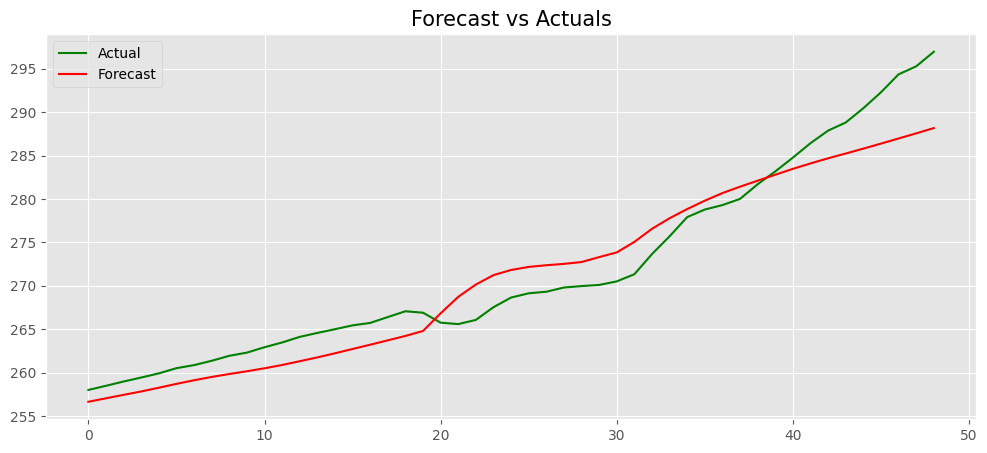

In [1558]:
plt.figure(figsize = (12, 5))
plt.plot(ML_ytest, label = "Actual", color = "green")
plt.plot(ML_yhat, label = "Forecast", color = "red")

plt.title("Forecast vs Actuals", fontsize = 15)
plt.legend(fontsize = 10)
plt.show()